In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from utils import dataset, plots, metrics

from torch.utils.data import DataLoader

In [2]:
seed = 0
batch_size = 32
nw = 4
n_epochs = 50
num_classes = 3

In [3]:
# model
class CNN(nn.Module):

    def __init__(self):
        super().__init__() 

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=256, 
                      kernel_size=16, 
                      stride=4),
            nn.MaxPool1d(kernel_size=4, stride = 1), # default stride: kernel_size :))
            nn.Dropout(0.5),
            nn.ReLU(True))
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=256, 
                      out_channels=128, 
                      kernel_size=8, 
                      stride=2),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.5),
            nn.ReLU(True))
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=128, 
                      out_channels=64, 
                      kernel_size=8, 
                      stride=2),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True))

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=4, 
                      stride=1),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(0.1)
        )
        
        self.lin = nn.Linear(in_features=64, 
                      out_features=3)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # apply conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.squeeze(-1) # remove last dim that is 1
        # apply linear layer
        out = self.lin(x)
        # apply softmax
        out = self.softmax(out)
        return out 

In [4]:
# load data
train_set = dataset.GW_dataset('training')
valid_set = dataset.GW_dataset('validation')
test_set = dataset.GW_dataset('test')

In [5]:
train_set.__len__()

989998

In [6]:
valid_set.__len__()

247499

In [7]:
test_set.__len__()

412499

In [8]:
train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=nw)
valid_DL = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=nw)
test_DL = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=nw)

In [9]:
# check if a cuda GPU is available
if torch.cuda.is_available():
    print('GPU availble')
    # define the device
    device = torch.device("cuda")
else:
    print('GPU not availble')
    device = torch.device("cpu")

print(f"SELECTED DEVICE: {device}")

GPU availble
SELECTED DEVICE: cuda


In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

cnn_net = CNN().to(device)

# loss
loss_function = nn.CrossEntropyLoss()

# optimizer
cnn_opt = optim.Adam(cnn_net.parameters())

train_loss_log = []
train_acc_log = []

val_loss_log = []
val_acc_log = []

# training/validation loop
for epoch in range(n_epochs):
    print(f"\n-----------------\nEpoch {epoch+1}/{n_epochs}\n-----------------")

    train_loss = []
    correct_counts = torch.zeros(num_classes, device=device)
    total_counts = torch.zeros(num_classes, device=device)

    # training
    for sample in train_DL:
        # data to device
        # sample shape: (B, 1, signal_length)
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        # forward pass
        out = cnn_net(xb)

        # loss
        loss = loss_function(out, yb)

        # backpropagation
        cnn_opt.zero_grad()
        loss.backward()

        # weight update
        cnn_opt.step()

        # log loss
        loss_b = l.detach().cpu().numpy()
        train_loss.append(loss_b)

        # accuracy
        preds = out.argmax(dim=1)
        for c in range(num_classes):
            mask = (yb == c)
            correct_counts[c] += (preds[mask] == c).sum()
            total_counts[c] += mask.sum()

    # average loss and accuracy
    avg_loss = np.mean(train_loss)
    avg_acc = {c: (correct_counts[c] / total_counts[c]).item() if total_counts[c] > 0 else np.nan for c in range(num_classes)}

    train_loss_log.append(avg_loss)
    train_acc_log.append(avg_acc)

    print(f"Train loss: {avg_loss:.4f}")
    for c, acc in avg_acc.items():
        print(f"  Class {c} accuracy: {acc:.4f}")

    # validation
    val_loss = []
    correct_counts = torch.zeros(num_classes, device=device)
    total_counts = torch.zeros(num_classes, device=device)
    cnn_net.eval()
    with torch.no_grad():
        for sample in valid_DL:
            # data to device
            xb = sample[0].float().to(device)
            yb = sample[1].long().to(device)

            # forward 
            out = cnn_net(xb)

            # loss
            l = loss_function(out, yb)

            # save
            loss_b = l.detach().cpu().numpy()
            val_loss.append(loss_b)

            # accuracy
            preds = out.argmax(dim=1)
            for c in range(num_classes):
                mask = (yb == c)
                correct_counts[c] += (preds[mask] == c).sum()
                total_counts[c] += mask.sum()
        
        val_loss = np.mean(val_loss)
        print('Validation loss:', val_loss)
        val_loss_log.append(val_loss)

        val_acc = {c: (correct_counts[c] / total_counts[c]).item() if total_counts[c] > 0 else np.nan for c in range(num_classes)}
        val_acc_log.append(val_acc)

        for c, acc in avg_acc.items():
            print(f"  Class {c} accuracy: {acc:.4f}")

In [ ]:
plots.plot_loss_acc('CNN', train_loss_log, val_acc_log, train_acc_log, val_acc_log)

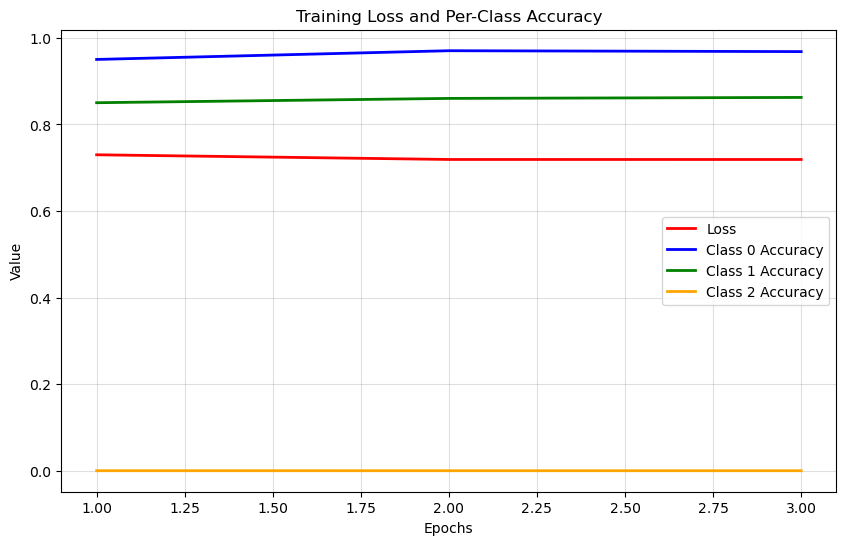

In [12]:
# epochs
epochs = np.arange(1, len(train_loss_log) + 1)

# Convert train_acc_log (list of dicts) to a dict of lists for each class
num_classes = len(train_acc_log[0])
per_class_acc = {c: [epoch_acc[c] for epoch_acc in train_acc_log] for c in range(num_classes)}

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.grid(alpha=0.4)

# Plot loss
ax.plot(epochs, train_loss_log, label='Loss', color='red', linewidth=2)

# Plot per-class accuracy
colors = ['blue', 'green', 'orange', 'purple', 'brown']  # extend if more classes
for c in range(num_classes):
    ax.plot(epochs, per_class_acc[c], label=f'Class {c} Accuracy', color=colors[c % len(colors)], linewidth=2)

ax.set_xlabel('Epochs')
ax.set_ylabel('Value')
ax.set_title('Training Loss and Per-Class Accuracy')
ax.legend()

plt.show()